# ts_for_contextual_bandit

## Demonstration of Thompson Sampling for the Contextual Multi-Armed Bandit Problem

In this Notebook, we tackle a more complex bandit problem: the Contextual Bandit, and show how we can apply Thompson Sampling to solve it.

In [4]:
# plotting inline
%matplotlib inline

# working directory
#import os; os.chdir('/home/gdmarmerola/ts_demo')

# importing necessary modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import beta as beta_dist
from scipy.stats import norm as norm_dist
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
from sklearn.linear_model import SGDClassifier, LogisticRegression
from scipy.optimize import minimize
from statsmodels.tools.tools import add_constant
import matplotlib.animation as animation
import warnings
warnings.filterwarnings('ignore')

# turning off automatic plot showing, and setting style
plt.ioff()
plt.style.use('fivethirtyeight')

Writer = animation.writers['ffmpeg']
writervideo = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

## Problem: the Contextual Bandit

The Contextual Bandit is just like the Multi-Armed bandit problem but now the reward probability distribution depends on external variables. Therefore, we add the notion of **context** or **state** to support our decision.

<img src = "1*3NziBtrANN6UVltplxwaGA.png", width=800px>

We're going to suppose that the probabilty of reward now is of the form

$$\theta_k(x) = \frac{1}{1 + exp(-f(x))}$$

where 

$$f(x) = \beta_0 + \beta_1 \cdot x + \epsilon$$

which is just assuming that the probability of reward for each bandit linearly depends of an external variable $x$ with logistic link. Let us implement this.

In [15]:
# class to implement our contextual bandit setting
class ContextualMAB:
    
    # initialization
    def __init__(self):
        
        # we build two bandits
        self.weights = {}
        self.weights[0] = [0.0, 1.6]
        self.weights[1] = [0.0, 0.4]
    
    # method for acting on the bandits
    def draw(self, k, x):
        
        # probability dict
        prob_dict = {}
        
        # loop for each bandit
        for bandit in self.weights.keys():
        
            # linear function of external variable
            f_x = self.weights[bandit][0] + self.weights[bandit][1]*x

            # generate reward with probability given by the logistic
            probability = 1/(1 + np.exp(-f_x))
            
            # appending to dict
            prob_dict[bandit] = probability
        
        # give reward according to probability
        return np.random.choice([0,1], p=[1 - prob_dict[k], prob_dict[k]]), max(prob_dict.values()) - prob_dict[k], prob_dict[k]

In [16]:
# instance of our class
cmab = ContextualMAB()

Let us visualize how the contexual MAB setting will work. First, let us see how the bandit probabilities depend on $x$.

In [4]:
# our x sample
X = np.linspace(-6, 6, 1500)

# computing bandit probabilities and storing to a dict
bandit_probs = {'x': X, 
                'b0': [cmab.draw(0, x_i)[2] for x_i in X], 
                'b1': [cmab.draw(1, x_i)[2] for x_i in X]}

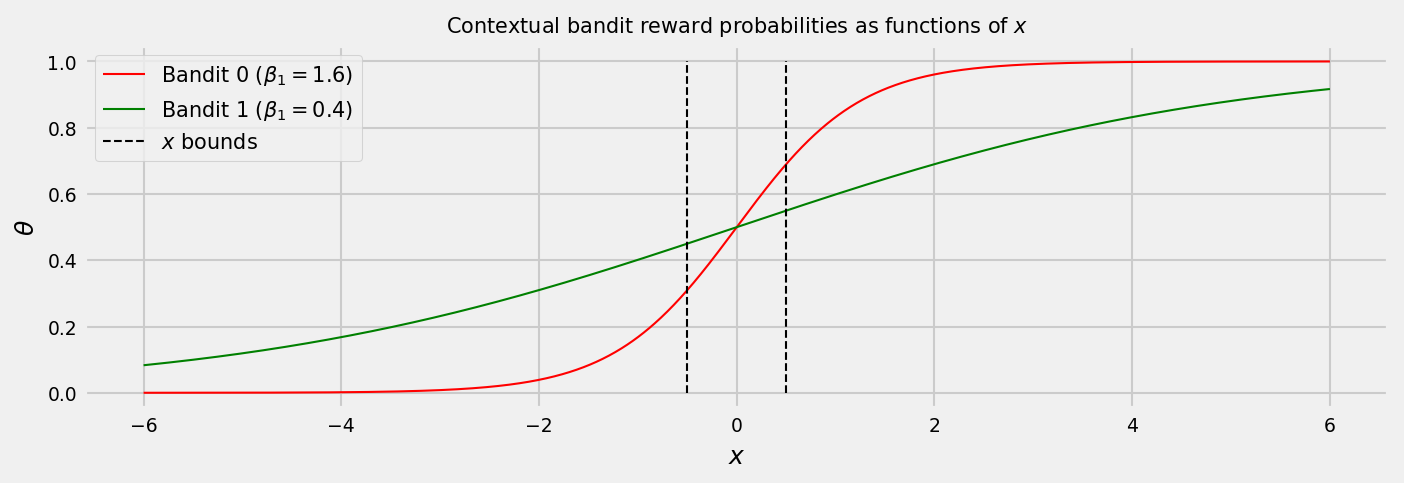

In [5]:
# clearing past figures
plt.close('all')

# colors for each bandit
bandit_colors = ['red', 'green']

# showing in a plot
plt.figure(figsize=[10,3], dpi=150)

# plotting bandit 0
plt.plot(bandit_probs['x'], bandit_probs['b0'], label='Bandit 0 ($\\beta_1 = 1.6$)', linewidth=1, color=bandit_colors[0])

# plotting bandit 1
plt.plot(bandit_probs['x'], bandit_probs['b1'], label='Bandit 1 ($\\beta_1 = 0.4$)', linewidth=1, color=bandit_colors[1])

# title and more formatting
plt.title('Contextual bandit reward probabilities as functions of $x$', fontsize=10);
plt.ylabel('$\\theta$', fontsize=12); plt.xlabel('$x$', fontsize=12)
plt.xticks(fontsize=9); plt.yticks(fontsize=9);

# showing our variable bounds
plt.plot([-0.5,-0.5],[0.0,1.0],'k--',label='$x$ bounds',linewidth=1)
plt.plot([0.5,0.5],[0.0,1.0],'k--',linewidth=1)

# showing
plt.legend(fontsize=10)
plt.show()

plt.savefig("contextualRewardProb.jpg")


The plot shows us that an ideal strategy would select Bandit 0 if $x$ is greater than 0, and Bandit 1 if $x$ is less than 0. In the following plot, we show the bandits rewards over time depending on a sine wave varying $x$. The green and red shaded areas show the best action at each time.

In [6]:
# let us create a function for the output of x
# it is a sine wave with period equal to 50 draws
# we're going to limit the amplitude of the sine wave such that the probabilities are not much different
def get_context(draw_number):
    return np.sin(draw_number*2*np.pi/100)*0.5

In [7]:
# we will use a random decision policy for illustration purposes
class RandomPolicy:
    
    # initializing
    def __init__(self, n_bandits):
        self.n_bandits = n_bandits
    
    # random bandit choice
    def choose_bandit(self, round_df, x):
        return np.random.choice(range(self.n_bandits),1)[0]

In [8]:
# function for plotting 
def plot_CMAB_experiment(decision_policy, N_DRAWS, plot_title, name):

    # clearing past figures
    plt.close('all')

    # Contextual MAB object
    cmab = ContextualMAB()

    # number of bandits
    N_BANDITS = len(cmab.weights.keys())

    # lists for accumulating draws, bandit choices and rewards
    k_list = []
    reward_list = []

    # df for accumulating draws and results
    round_df = pd.DataFrame({'k': [], 'x': [], 'reward': []})

    # colors for each bandit
    bandit_colors = ['red', 'green']

    # opening figure
    fig = plt.figure(figsize=(9,5), dpi=150)

    # let us position our plots in a grid, the largest being our plays
    ax1 = plt.subplot2grid((5, 4), (0, 0), colspan=4, rowspan=3)
    ax2 = plt.subplot2grid((5, 4), (3, 0), colspan=4, rowspan=2)

    # loop generating draws
    for draw_number in range(N_DRAWS):

        # record information about this draw
        x = get_context(draw_number)
        k = decision_policy(round_df, x)
        reward, regret, prob = cmab.draw(k, x)

        # record information about this draw
        k_list.append(k)
        reward_list.append(reward)

        # getting list of colors that tells us the bandit
        color_list = [bandit_colors[k] for k in k_list]

        # getting list of facecolors that tells us the reward
        facecolor_list = [['none', bandit_colors[k_list[i]]][r] for i, r in enumerate(reward_list)]
        
        # temporary df with data from this round
        temp_df = pd.DataFrame({'x': x, 'k': k, 'reward': reward}, index=[draw_number])
        
        # accumulating in main df
        round_df = pd.concat([round_df, temp_df])

    # fixing properties of the plots
    ax1.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))
    ax1.set_title(plot_title, fontsize=10)
    ax1.set_xlabel('Round', fontsize=10); ax1.set_ylabel('Bandit', fontsize=10)
    ax2.set_title('Value of the context variable $x$', fontsize=10)
    ax2.set_xlabel('Round', fontsize=10); ax2.set_ylabel('$x$', fontsize=10)
    ax2.set(xlim=(-1, N_DRAWS))

    # titles of distribution plots

    # initializing with first data
    scatter = ax1.scatter(y=[k_list[0]], x=[list(range(N_DRAWS))[0]], color=[color_list[0]], linestyle='-', marker='o', s=30, facecolor=[facecolor_list[0]]);
    x_line = ax2.plot(list(range(N_DRAWS)), [get_context(i) for i in range(N_DRAWS)], 'k--', linewidth=2)

    # filling area to show optimal action at each point
    ax1.fill_between(x=[0,50], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[0], alpha=0.05)
    ax1.fill_between(x=[50,100], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[1], alpha=0.05)
    ax1.fill_between(x=[100,150], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[0], alpha=0.1)
    ax1.fill_between(x=[150,200], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[1], alpha=0.1)

    # filling area to show optimal action at each point
    ax2.fill_between(x=[0,50], y1=[1,1], y2=[-1,-1], color=bandit_colors[0], alpha=0.1)
    ax2.fill_between(x=[50,100], y1=[1,1], y2=[-1,-1], color=bandit_colors[1], alpha=0.1)
    ax2.fill_between(x=[100,150], y1=[1,1], y2=[-1,-1], color=bandit_colors[0], alpha=0.1)
    ax2.fill_between(x=[150,200], y1=[1,1], y2=[-1,-1], color=bandit_colors[1], alpha=0.1)

    # titles
    #plt.title('Random draws from the row of slot machines (MAB)', fontsize=10)
    #plt.xlabel('Round', fontsize=10); plt.ylabel('Bandit', fontsize=10);

    # function for updating
    def animate(i):

        # clearing axes
        ax1.clear(); 

        # updating game rounds
        scatter = ax1.scatter(y=k_list[:i], x=list(range(N_DRAWS))[:i], color=color_list[:i], 
                              linestyle='-', marker='o', s=30, facecolor=facecolor_list[:i]);

        # filling area to show optimal action at each point
        ax1.fill_between(x=[0,50], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[0], alpha=0.1)
        ax1.fill_between(x=[50,100], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[1], alpha=0.1)
        ax1.fill_between(x=[100,150], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[0], alpha=0.1)
        ax1.fill_between(x=[150,200], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[1], alpha=0.1)

        # fixing properties of the plot
        ax1.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))
        ax1.set_title(plot_title, fontsize=10)
        ax1.set_xlabel('Round', fontsize=10); ax1.set_ylabel('Bandit', fontsize=10)
        ax2.set_title('Value of the context variable $x$', fontsize=10)
        ax2.set_xlabel('Round', fontsize=10); ax2.set_ylabel('$x$', fontsize=10)
        ax2.set(xlim=(-1, N_DRAWS))

        # do not need to return 
        return ()

    # function for creating animation
    anim = FuncAnimation(fig, animate, frames=N_DRAWS, interval=200, blit=True)

    # fixing the layout
    fig.tight_layout()
    anim.save(name+'_01.mp4', writer=writervideo)
    # showing
    # return HTML(anim.to_html5_video())
    #return round_df

In [9]:
# instance of random policy
rand_policy = RandomPolicy(n_bandits=2)

In [10]:
# plotting
plot_CMAB_experiment(rand_policy.choose_bandit, 200, 'Random draws from the Contextual MAB setting','RandomCB')

We can see that the reward probabilities change for the bandits according to $x$. Our bandit algorithms will have to adapt to this scenario. Let us implement them.

## Algorithm 1: $\epsilon$-greedy with regular Logistic Regression

Let us implement a regular logistic regression, and use an $\epsilon$-greedy policy to choose which bandit to activate. We try to learn the logistic function behind each bandit:

$$\theta_k(x) = \frac{1}{1 + exp(-f(x))}$$

where 

$$f(x) = \beta_0 + \beta_1 \cdot x + \epsilon$$

And select the bandit which maximizes $\theta(x)$, except when, with $\epsilon$ probability, we select a random action (excluding the greedy action).

In [11]:
# Logistic Regression with e-greedy policy class
class EGreedyLR:
    
    # initialization
    def __init__(self, epsilon, n_bandits, buffer_size=200):
    
        # storing epsilon, number of bandits, and buffer size
        self.epsilon = epsilon
        self.n_bandits = n_bandits
        self.buffer_size = buffer_size
    
    # function to fit and predict from a df
    def fit_predict(self, data, actual_x):
        
        # sgd object
        logreg = LogisticRegression(fit_intercept=False)
        
        # fitting to data
        logreg.fit(data['x'].values.reshape(-1,1), data['reward'])
        
        # returning probabilities
        return logreg.predict_proba(actual_x.reshape(-1,1))[0][1]
    
    # decision function
    def choose_bandit(self, round_df, actual_x):
        
        # enforcing buffer size
        round_df = round_df.tail(self.buffer_size)
        
        # if we have enough data, calculate best bandit
        if round_df.groupby(['k','reward']).size().shape[0] == 4:
        
            # predictinng for two of our datasets
            bandit_scores = round_df.groupby('k').apply(self.fit_predict, actual_x=actual_x)

            # get best bandit
            best_bandit = int(bandit_scores.idxmax())
        
        # if we do not have, the best bandit will be random
        else:
            best_bandit = int(np.random.choice(list(range(self.n_bandits)),1)[0])
        
        # choose greedy or random action based on epsilon
        if np.random.random() > self.epsilon:
            return best_bandit
        else:
            return int(np.random.choice(np.delete(list(range(self.n_bandits)), best_bandit),1)[0])

In [12]:
# instance of class
egreedy_lr = EGreedyLR(epsilon=0.1, n_bandits=2)

In [13]:
# plotting
plot_CMAB_experiment(egreedy_lr.choose_bandit, 200, '$\epsilon$-greedy strategy decisions over time','EGreedyCB')

As we may see on multiple runs, it may take long for the e-greedy algorithm to start selecting the arms at the right times. It's very likely that it gets stuck on a suboptimal actions for a long time. 

Let us use Thompson Sampling for more efficient exploration.

## Algorithm 2: Online Logistic Regression by Chapelle et. al

In 2011, Chapelle & Li published the paper "[An Empirical Evaluation of Thompson Sampling](https://papers.nips.cc/paper/4321-an-empirical-evaluation-of-thompson-sampling.pdf)" that helped revive the interest on Thompson Sampling, showing favorable empirical results in comparison to other heuristics. We're going to borrow the Online Logistic Regression algorithm (Algorithm 3) from the paper. Basically, it's a bayesian logistic regression where we define a prior distribution for our weights $\beta_0$ and $\beta_1$, instead of learning just a single value for them (the expectation of the distribution). 

So, our model, just like the greedy algorithm, is:

$$\theta_k = \frac{1}{1 + exp(-f(x))}$$

where 

$$f(x) = \beta_0 + \beta_1 \cdot x + \epsilon$$

but the weights are actually assumed to be distributed as independent gaussians:

$$\beta_i = \mathcal{N}(m_i,q_i^{-1})$$

We initialize all $q_i$'s with a hyperparamenter $\lambda$, which is equivalent to the $\lambda$ used in L2 regularization. Then, at each new training example (or batch of examples) we make the following calculations:

1. Find $\textbf{w}$ as the minimizer of $\frac{1}{2}\sum_{n=1}^{d} q_i(w_i - m_i)^2 + \sum_{j=1}^{n} \textrm{log}(1 + \textrm{exp}(-y_jw^Tx_j))$
2. Update $m_i = w_i$ and perform $q_i = q_i + \sum_{j=1}^{n} x^2_{ij}p_j(1-p_j)$ where $p_j = (1 + \textrm{exp}( -w^Tx_j))^{-1}$ (Laplace approximation)

There are some heavy maths, but in essence, we basically altered the logistic regression fitting process to accomodate distributions for the weights. Our Normal priors on the weights are iteratively updated and as the number of observations grow, our uncertainty over their means is reduced. 

We can also increase incentives for exploration or exploitation by defining a hyperparameter $\alpha$, which multiplies the variance of the Normal priors:

$$\beta_i = \mathcal{N}(m_i,\alpha \cdot{} q_i^{-1})$$

With $0 < \alpha < 1$ we reduce the variance of the Normal priors, inducing the algorithm to be greedier, whereas with $\alpha > 1$ we prioritize exploration. Let us implement the algorithm.

In [18]:
# defining a class for our online bayesian logistic regression
class OnlineLogisticRegression:
    
    # initializing
    def __init__(self, lambda_, alpha, n_dim):
        
        # the only hyperparameter is the deviation on the prior (L2 regularizer)
        self.lambda_ = lambda_; self.alpha = alpha
                
        # initializing parameters of the model
        self.n_dim = n_dim, 
        self.m = np.zeros(self.n_dim)
        self.q = np.ones(self.n_dim) * self.lambda_
        
        # initializing weights
        self.w = np.random.normal(self.m, self.alpha * (self.q)**(-1.0), size = self.n_dim)
        
    # the loss function
    def loss(self, w, *args):
        X, y = args
        return 0.5 * (self.q * (w - self.m)).dot(w - self.m) + np.sum([np.log(1 + np.exp(-y[j] * w.dot(X[j]))) for j in range(y.shape[0])])
        
    # the gradient
    def grad(self, w, *args):
        X, y = args
        return self.q * (w - self.m) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis=0)
    
    # method for sampling weights
    def get_weights(self):
        return np.random.normal(self.m, self.alpha * (self.q)**(-1.0), size = self.n_dim)
    
    # fitting method
    def fit(self, X, y):
                
        # step 1, find w
        self.w = minimize(self.loss, self.w, args=(X, y), jac=self.grad, method="L-BFGS-B", options={'maxiter': 20, 'disp':True}).x
        self.m = self.w
        
        # step 2, update q
        P = (1 + np.exp(-1*X.dot(self.m))) ** (-1)
        self.q = self.q + (P*(1-P)).dot(X ** 2)
                
    # probability output method, using weights sample
    def predict_proba(self, X, mode='sample'):
        
        # adding intercept to X
        #X = add_constant(X)
        
        # sampling weights after update
        self.w = self.get_weights()
        
        # using weight depending on mode
        if mode == 'sample':
            w = self.w # weights are samples of posteriors
        elif mode == 'expected':
            w = self.m # weights are expected values of posteriors
        else:
            raise Exception('mode not recognized!')
        
        # calculating probabilities
        proba = 1 / (1 + np.exp(-1 * X.dot(w)))
        return np.array([1-proba , proba]).T

In [19]:
# let us fit this model to some data #

# ground truth
X = np.random.uniform(-6, 6, 10)
y = np.array([cmab.draw(0, x)[0] for x in X])

# OLR object
online_lr = OnlineLogisticRegression(0.5, 1, 1)
online_lr.fit(X.reshape(-1,1), y)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.96959D+01    |proj g|=  1.48483D+01

At iterate    1    f=  7.15709D+00    |proj g|=  7.65498D+00

At iterate    2    f=  4.90709D+00    |proj g|=  5.00171D-01

At iterate    3    f=  4.87820D+00    |proj g|=  3.82508D-01

At iterate    4    f=  4.84856D+00    |proj g|=  1.48104D-01

At iterate    5    f=  4.84515D+00    |proj g|=  2.84744D-02

At iterate    6    f=  4.84500D+00    |proj g|=  1.75488D-03


 This problem is unconstrained.



At iterate    7    f=  4.84500D+00    |proj g|=  2.24058D-05

At iterate    8    f=  4.84500D+00    |proj g|=  1.73740D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      8      9      1     0     0   1.737D-08   4.845D+00
  F =   4.8450020192355430     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


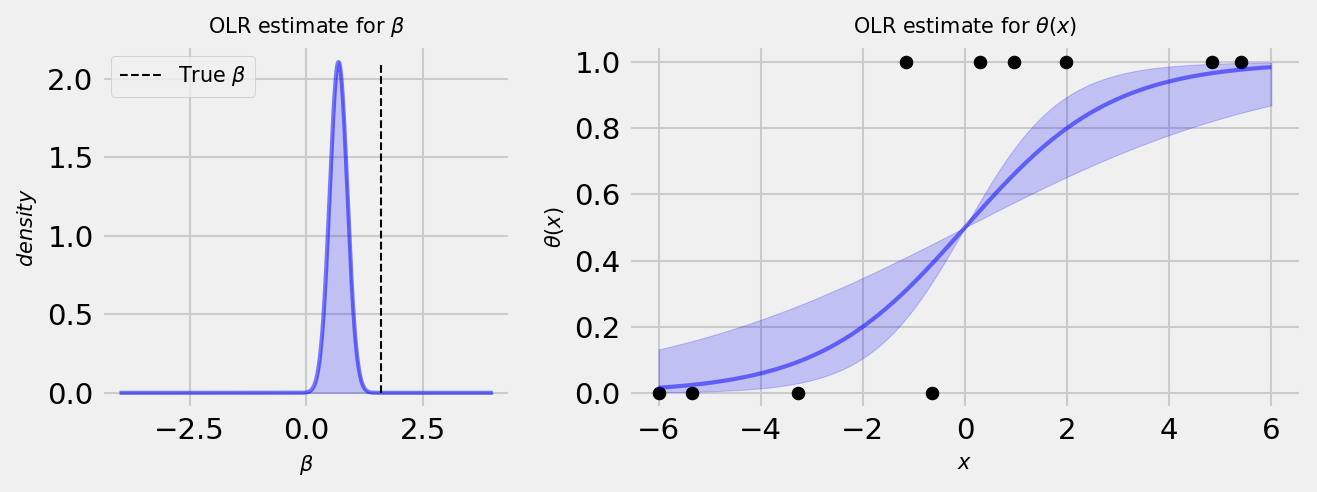

In [16]:
# closing other figures
plt.close('all')

# let us check the distribution of weights and uncertainty bounds
plt.figure(figsize=[9,3.5], dpi=150)

# plotting the pdf of the weight distribution
X_pdf = np.linspace(-4, 4, 1000)
pdf = norm_dist(loc=online_lr.m, scale=online_lr.q**(-1.0)).pdf(X_pdf)

# range and resolution of probability plot
X_prob = np.linspace(-6, 6, 1000)
p_dist = 1/(1 + np.exp(-X_prob * online_lr.m))
p_dist_plus = 1/(1 + np.exp(-X_prob * (online_lr.m + 2*online_lr.q**(-1.0))))
p_dist_minus = 1/(1 + np.exp(-X_prob * (online_lr.m - 2*online_lr.q**(-1.0))))

# opening subplots
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=3, rowspan=1)

# plotting distriution of weights
ax1.plot(X_pdf, pdf, color='b', linewidth=2, alpha=0.5)
ax1.plot([cmab.weights[0][1], cmab.weights[0][1]], [0, max(pdf)], 'k--', label='True $\\beta$', linewidth=1)
ax1.fill_between(X_pdf, pdf, 0, color='b', alpha=0.2)

# plotting probabilities
ax2.plot(X_prob, p_dist, color='b', linewidth=2, alpha=0.5)
ax2.fill_between(X_prob, p_dist_plus, p_dist_minus, color='b', alpha=0.2)
ax2.scatter(X, y, c='k')

# title and comments
ax1.set_title('OLR estimate for $\\beta$', fontsize=10)
ax1.set_xlabel('$\\beta$', fontsize=10); ax1.set_ylabel('$density$', fontsize=10)
ax2.set_title('OLR estimate for $\\theta(x)$', fontsize=10)
ax2.set_xlabel('$x$', fontsize=10); ax2.set_ylabel('$\\theta(x)$', fontsize=10)

ax1.legend(fontsize=10)
plt.tight_layout()
plt.show()
plt.savefig("cbest.jpg")

In [17]:
# we can sample the output of the OLR!
online_lr.predict_proba(np.array([1.5]))

array([0.16691024, 0.83308976])

Great. So the Online Logistic Regression gives us not only a point estimate for the weights and probabilities, but the uncertainty around these estimates. This way, it is very simple to use Thompson Sampling: we perform an OLR for each bandit, take a sample of the posterior of $\beta$, get the sampled output and choose the bandit with the highest probability. 

In [8]:
# now, we define a class for our policy
class ThompsonSamplingLR:
    
    # initializing policy parameters
    def __init__(self, lambda_, alpha, n_bandits, buffer_size=200):
        
        # storing the parameters
        self.lambda_ = lambda_
        self.n_bandits = n_bandits
        self.alpha = alpha
        self.buffer_size = buffer_size
    
    # function to fit and predict from a df
    def fit_predict(self, data, actual_x):
        
        # sgd object
        olr = OnlineLogisticRegression(self.lambda_, self.alpha, 1)
        
        # fitting to data
        olr.fit(data['x'].values.reshape(-1,1), data['reward'].values)
            
        # data frame with probabilities and model parameters
        out_df = pd.DataFrame({'prob': olr.predict_proba(np.array(actual_x))[0][1],
                               'm': olr.m, 'q': olr.q * (self.alpha) ** (-1.0)})
            
        # returning probabilities
        return out_df
    
    # decision function
    def choose_bandit(self, round_df, actual_x):
        
        # enforcing buffer size
        round_df = round_df.tail(self.buffer_size)
        
        # if we have enough data, calculate best bandit
        if round_df.groupby(['k','reward']).size().shape[0] == 4:
        
            # predictinng for two of our datasets
            self.ts_model_df = (round_df
                                .groupby('k')
                                .apply(self.fit_predict, actual_x=actual_x)
                                .reset_index().drop('level_1', axis=1).set_index('k'))

            # get best bandit
            best_bandit = int(self.ts_model_df['prob'].idxmax())
        
        # if we do not have, the best bandit will be random
        else:
            best_bandit = int(np.random.choice(list(range(self.n_bandits)),1)[0])
            self.ts_model_df = pd.DataFrame({'prob': 0.50, 'm': 0.0, 'q': self.lambda_}, index=[0])

        # return best bandit
        return best_bandit

In [19]:
# instance of class
tsampling_lr = ThompsonSamplingLR(lambda_=5, alpha=5.0, n_bandits=2)

In [20]:
# plotting
plot_CMAB_experiment(tsampling_lr.choose_bandit, 200, 'Thompson Sampling decisions over time','tsCB')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71416D+00    |proj g|=  1.81070D+00

At iterate    1    f=  1.38629D+00    |proj g|=  2.77556D-16

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   2.776D-16   1.386D+00
  F =   1.3862943611198906     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    2    f=  7.60639D+00    |proj g|=  2.17142D-05

At iterate    3    f=  7.60639D+00    |proj g|=  8.98261D-11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   8.983D-11   7.606D+00
  F =   7.6063881662837796     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.52680D+00    |proj g|=  5.37698D-01

At iterate    1    f=  5.49863D+00    |proj g|=  6.38100D-05

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33902D+01    |proj g|=  3.41722D+00

At iterate    1    f=  1.26224D+01    |proj g|=  1.88115D+00

At iterate    2    f=  1.22883D+01    |proj g|=  6.09244D-04

At iterate    3    f=  1.22883D+01    |proj g|=  2.45562D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   2.456D-07   1.229D+01
  F =   12.288343394510841     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68445D+01    |proj g|=  3.07077D+00

At iterate    1    f=  1.65396D+01    |proj g|=  2.45749D+00

At iterate    2    f=  1.59925D+01    |proj g|=  2.71407D-03

At iterate    3    f=  1.59925D+01    |proj g|=  3.37629D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   3.376D-06   1.599D+01
  F =   15.992544152203322     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    2    f=  1.95381D+01    |proj g|=  1.07599D-02

At iterate    3    f=  1.95381D+01    |proj g|=  7.44520D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   7.445D-06   1.954D+01
  F =   19.538103911703921     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29932D+01    |proj g|=  4.48865D+00

At iterate    1    f=  2.12220D+01    |proj g|=  9.46075D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97188D+01    |proj g|=  7.91746D+00

At iterate    1    f=  2.45249D+01    |proj g|=  2.46587D+00

At iterate    2    f=  2.39682D+01    |proj g|=  4.40905D-03

At iterate    3    f=  2.39682D+01    |proj g|=  1.44231D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   1.442D-06   2.397D+01
  F =   23.968231989577028     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    2    f=  2.75769D+01    |proj g|=  8.07118D-03

At iterate    3    f=  2.75769D+01    |proj g|=  1.54988D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   1.550D-06   2.758D+01
  F =   27.576868448706545     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64941D+01    |proj g|=  3.74409D+00

At iterate    1    f=  2.55640D+01    |proj g|=  1.88190D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    2    f=  2.96226D+01    |proj g|=  1.17330D-03

At iterate    3    f=  2.96226D+01    |proj g|=  9.10646D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   9.106D-07   2.962D+01
  F =   29.622644071354255     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45598D+01    |proj g|=  6.84282D+00

At iterate    1    f=  3.05588D+01    |proj g|=  1.15240D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    1    f=  3.53460D+01    |proj g|=  3.38874D-04

At iterate    2    f=  3.53460D+01    |proj g|=  9.29233D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   9.292D-09   3.535D+01
  F =   35.346037006117093     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42416D+01    |proj g|=  6.09345D+00

At iterate    1    f=  3.10191D+01    |proj g|=  3.42268D-01

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   3.066D-08   3.950D+01
  F =   39.502913991036543     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37493D+01    |proj g|=  2.05878D-02

At iterate    1    f=  3.37493D+01    |proj g|=  1.94086D-05

At iterate    2    f=  3.37493D+01    |proj g|=  1.18185D-10

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06889D+01    |proj g|=  5.24473D+00

At iterate    1    f=  3.83944D+01    |proj g|=  6.55655D-01

At iterate    2    f=  3.83579D+01    |proj g|=  5.27569D-04

At iterate    3    f=  3.83579D+01    |proj g|=  1.69100D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   1.691D-07   3.836D+01
  F =   38.357935522687796     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.21363D+01    |proj g|=  2.32974D-01

At iterate    1    f=  4.21319D+01    |proj g|=  2.36529D-04

At iterate    2    f=  4.21319D+01    |proj g|=  3.72562D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   3.726D-08   4.213D+01
  F =   42.131878508261728     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   1.514D-08   4.421D+01
  F =   44.209317523968160     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.91712D+01    |proj g|=  6.03835D+00

At iterate    1    f=  4.63215D+01    |proj g|=  3.33712D-01

At iterate    2    f=  4.63128D+01    |proj g|=  1.25097D-03

At iterate    3    f=  4.63128D+01    |proj g|=  4.65057D-07

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    3    f=  4.81786D+01    |proj g|=  6.15294D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   6.153D-06   4.818D+01
  F =   48.178602053064189     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70369D+01    |proj g|=  1.07822D+01

At iterate    1    f=  4.92986D+01    |proj g|=  4.67764D+00

At iterate    2    f=  4.75211D+01    |proj g|=  3.90017D-02

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.91232D+01    |proj g|=  4.44115D+00

At iterate    1    f=  4.77595D+01    |proj g|=  1.71205D+00

At iterate    2    f=  4.75210D+01    |proj g|=  1.93203D-03

At iterate    3    f=  4.75210D+01    |proj g|=  2.04310D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   2.043D-06   4.752D+01
  F =   47.520974708981591     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.17909D+01    |proj g|=  1.11646D+00

At iterate    1    f=  5.16897D+01    |proj g|=  8.39782D-04

At iterate    2    f=  5.16897D+01    |proj g|=  3.55856D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   3.559D-07   5.169D+01
  F =   51.689731659689471     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10



 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.59449D+01    |proj g|=  1.52843D+01

At iterate    1    f=  6.38498D+01    |proj g|=  8.88281D+00

At iterate    2    f=  5.77602D+01    |proj g|=  1.02393D-01

At iterate    3    f=  5.77594D+01    |proj g|=  4.36441D-04

At iterate    4    f=  5.77594D+01    |proj g|=  5.32318D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      4      5      1     0     0   5.323D-08   5.776D+01
  F =   57.759431090688608     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    2    f=  5.73903D+01    |proj g|=  6.65232D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   6.652D-09   5.739D+01
  F =   57.390284683213594     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.02351D+01    |proj g|=  6.97984D-01

At iterate    1    f=  6.01980D+01    |proj g|=  1.48825D-03

At iterate    2    f=  6.01980D+01    |proj g|=  1.21567D-06

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    2    f=  6.16637D+01    |proj g|=  2.37343D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   2.373D-06   6.166D+01
  F =   61.663724250834392     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.34104D+01    |proj g|=  4.87093D+00

At iterate    1    f=  6.17932D+01    |proj g|=  1.65756D+00

At iterate    2    f=  6.15843D+01    |proj g|=  1.10278D-02

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    3    f=  6.51555D+01    |proj g|=  7.13572D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   7.136D-07   6.516D+01
  F =   65.155507698815057     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.31422D+01    |proj g|=  1.50232D+00

At iterate    1    f=  6.29706D+01    |proj g|=  9.74048D-04

At iterate    2    f=  6.29706D+01    |proj g|=  1.44948D-06

        

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    1    f=  6.87793D+01    |proj g|=  1.46064D+00

At iterate    2    f=  6.86182D+01    |proj g|=  9.57983D-03

At iterate    3    f=  6.86182D+01    |proj g|=  1.06127D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   1.061D-06   6.862D+01
  F =   68.618156047014722     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.45301D+01    |proj g|=  6.22062D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


We can observe on many runs that thompson sampling has a somewhat of a learning curve, but rapidly converges to the right decisions. We can control the amount of exploration using $\alpha$, with the trade-off of possibly being stuck on a suboptiomal strategy or to incur heavy costs for better exploring the set of actions at our disposal.

## Visualizing the learning process

Let us visualize how the learning progresses and we get the probabilities we want for each bandit.

In [21]:
# function to get data on the distributions of the model parameters
def get_parameter_dists(param_df):
    
    # dict for storing the distributions
    dist_dict = {}
    
    # range and resolution of pdf plot
    X_pdf = np.linspace(-12, 12, 1000)
    
    # range and resolution of probability plot
    X_prob = np.linspace(-3, 3, 1000)
    
    # loop for each index
    for i, data in param_df.iterrows():
        
        # initializing dict
        dist_dict[i] = {}
        
        # distribution of weights
        dist_dict[i]['w_dist'] = norm_dist(loc=data['m'], scale=data['q']**(-1.0)).pdf(X_pdf)
        dist_dict[i]['x_pdf'] = X_pdf
        
        # probability and confidence intervals
        dist_dict[i]['p_dist'] = 1/(1 + np.exp(-X_prob * data['m']))
        dist_dict[i]['p_dist_+2std'] = 1/(1 + np.exp(-X_prob * (data['m'] + 2*data['q']**(-1.0))))
        dist_dict[i]['p_dist_-2std'] = 1/(1 + np.exp(-X_prob * (data['m'] - 2*data['q']**(-1.0))))
        dist_dict[i]['x_prob'] = X_prob
        
    # returning dict
    return dist_dict

In [9]:
# function that creates the learning process animation
def plot_TS_learning(N_DRAWS, plot_title, lambda_, alpha):

    # clearing past figures
    plt.close('all')

    # Contextual MAB object
    cmab = ContextualMAB()

    # number of bandits
    N_BANDITS = len(cmab.weights.keys())

    # lists for accumulating draws, bandit choices, rewards and data for distribution viz
    k_list = []
    reward_list = []
    dist_dict_list = []

    # df for accumulating draws and results
    round_df = pd.DataFrame({'k': [], 'x': [], 'reward': []})

    # colors for each bandit
    bandit_colors = ['red', 'green']

    # we'll use thompson sampling
    tsampling_lr = ThompsonSamplingLR(lambda_=lambda_, alpha=alpha, n_bandits=2)

    # opening figure
    fig = plt.figure(figsize=(9,7), dpi=150)

    # let us position our plots in a grid, the largest being our plays
    ax1 = plt.subplot2grid((10, 4), (0, 0), colspan=4, rowspan=4)
    ax2 = plt.subplot2grid((10, 4), (4, 0), colspan=4, rowspan=3)
    ax3 = plt.subplot2grid((10, 4), (7, 0), colspan=4, rowspan=3)

    # loop generating draws
    for draw_number in range(N_DRAWS):

        # record information about this draw
        x = get_context(draw_number)
        k = tsampling_lr.choose_bandit(round_df, x)
        reward, regret, prob = cmab.draw(k, x)

        # getting dict of distributions
        dist_dict_list.append(get_parameter_dists(tsampling_lr.ts_model_df))

        # record information about this draw
        k_list.append(k)
        reward_list.append(reward)

        # getting list of colors that tells us the bandit
        color_list = [bandit_colors[k] for k in k_list]

        # getting list of facecolors that tells us the reward
        facecolor_list = [['none', bandit_colors[k_list[i]]][r] for i, r in enumerate(reward_list)]

        # temporary df with data from this round
        temp_df = pd.DataFrame({'x': x, 'k': k, 'reward': reward}, index=[draw_number])

        # accumulating in main df
        round_df = pd.concat([round_df, temp_df])

    # fixing properties of the plots
    ax1.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))
    ax1.set_title(plot_title, fontsize=10)
    ax1.set_xlabel('Round', fontsize=10); ax1.set_ylabel('Bandit', fontsize=10)
    ax2.set_title('Probabilities of reward for each bandit and uncertainty', fontsize=10)
    ax2.set_xlabel('$x$', fontsize=10); ax2.set_ylabel('$\\theta_k$', fontsize=10)
    ax2.set(xlim=(-3, 3))
    ax3.set_title('Distributions over logistic regression weights', fontsize=10)
    ax3.set_xlabel('$x$', fontsize=10); ax3.set_ylabel('$PDF(\\beta)$', fontsize=10)
    ax3.set(xlim=(-12, 12))

    # initializing with first data
    ax1.scatter(y=[k_list[0]], x=[list(range(N_DRAWS))[0]], color=[color_list[0]], linestyle='-', marker='o', s=30, facecolor=[facecolor_list[0]]);

    # loop for ax2 to draw probabilities
    ax2.plot([round_df['x'].values[0], round_df['x'].values[0]],[0.0,1.0],'k--', label='$x$', linewidth=2)
    for key in dist_dict_list[0].keys():
        ax2.plot(dist_dict_list[0][key]['x_prob'], dist_dict_list[0][key]['p_dist'], color=bandit_colors[key], linewidth=2, alpha=0.5)
        ax2.fill_between(dist_dict_list[0][key]['x_prob'], dist_dict_list[0][key]['p_dist_+2std'], dist_dict_list[0][0.0]['p_dist_-2std'], 
                         color=bandit_colors[key], alpha=0.2)

    # loop for ax3 to draw densities
    for key in dist_dict_list[0].keys():
        ax3.plot(dist_dict_list[0][key]['x_pdf'], dist_dict_list[0][key]['w_dist'], color=bandit_colors[key], linewidth=2, alpha=0.5)
        ax3.fill_between(dist_dict_list[0][key]['x_pdf'], dist_dict_list[0][key]['w_dist'], 0, color=bandit_colors[key], alpha=0.2)


    # filling area to show optimal action at each point
    ax1.fill_between(x=[0,50], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[0], alpha=0.05)
    ax1.fill_between(x=[50,100], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[1], alpha=0.05)
    ax1.fill_between(x=[100,150], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[0], alpha=0.1)
    ax1.fill_between(x=[150,200], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[1], alpha=0.1)

    # function for updating
    def animate(i):

        # clearing axes
        ax1.clear(); ax2.clear(); ax3.clear();

        # fixing properties of the plots
        ax1.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))
        ax1.set_title(plot_title, fontsize=10)
        ax1.set_xlabel('Round', fontsize=10); ax1.set_ylabel('Bandit', fontsize=10)
        ax2.set_title('Probabilities of reward for each bandit and uncertainty', fontsize=10)
        ax2.set_xlabel('$x$', fontsize=10); ax2.set_ylabel('$\\theta_k$', fontsize=10)
        ax2.set(xlim=(-3, 3))
        ax3.set_title('Distributions over logistic regression weights', fontsize=10)
        ax3.set_xlabel('$x$', fontsize=10); ax3.set_ylabel('$PDF(\\beta)$', fontsize=10)
        ax3.set(xlim=(-12, 12))

        # initializing with first data
        ax1.scatter(y=k_list[:i], x=list(range(N_DRAWS))[:i], color=color_list[:i], linestyle='-', marker='o', s=30, facecolor=facecolor_list[:i]);

        # loop for ax2 to draw probabilities
        ax2.plot([round_df['x'].values[i], round_df['x'].values[i]],[0.0,1.0],'k--', label='$x$', linewidth=2)
        for key in dist_dict_list[i].keys():
            ax2.plot(dist_dict_list[i][key]['x_prob'], dist_dict_list[i][key]['p_dist'], color=bandit_colors[int(key)], linewidth=2, alpha=0.5)
            ax2.fill_between(dist_dict_list[i][key]['x_prob'], dist_dict_list[i][key]['p_dist_+2std'], dist_dict_list[i][key]['p_dist_-2std'], 
                             color=bandit_colors[int(key)], alpha=0.2)

        # loop for ax3 to draw densities
        for key in dist_dict_list[i].keys():
            ax3.plot(dist_dict_list[i][key]['x_pdf'], dist_dict_list[i][key]['w_dist'], color=bandit_colors[int(key)], linewidth=2, alpha=0.5)
            ax3.fill_between(dist_dict_list[i][key]['x_pdf'], dist_dict_list[i][key]['w_dist'], 0, color=bandit_colors[int(key)], alpha=0.2)


        # filling area to show optimal action at each point
        ax1.fill_between(x=[0,50], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[0], alpha=0.05)
        ax1.fill_between(x=[50,100], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[1], alpha=0.05)
        ax1.fill_between(x=[100,150], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[0], alpha=0.1)
        ax1.fill_between(x=[150,200], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[1], alpha=0.1)

        # do not need to return 
        return ()

    # function for creating animation
    anim = FuncAnimation(fig, animate, frames=N_DRAWS, interval=200, blit=True)

    # fixing the layout
    fig.tight_layout()
    ax2.legend()

    # showing
    return HTML(anim.to_html5_video())
    #return round_df

In [23]:
# let us visualize!
plot_TS_learning(200, 'Thompson Sampling learning process visuals', lambda_=5, alpha=5.0)

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.52307D+00    |proj g|=  3.25501D+00

At iterate    1    f=  3.77116D+00    |proj g|=  1.75120D+00

At iterate    2    f=  3.46487D+00    |proj g|=  6.61026D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   6.610D-07   3.465D+00
  F =   3.4648729701903482     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.95336D+00    |proj g|=  2.96621D-02

At iterate    1    f=  8.95328D+00    |proj g|=  3.59504D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   3.595D-06   8.953D+00
  F =   8.9532788987604537     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.79952D+01    |proj g|=  5.37992D+00

At iterate    1    f=  1.53743D+01    |proj g|=  1.46360D-01

At iterate    2    f=  1.53724D+01    |proj g|=  5.42028D-04

At iterate    3    f=  1.53724D+01    |proj g|=  3.26332D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   3.263D-08   1.537D+01
  F =   15.372354197897600     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.27901D+01    |proj g|=  5.47281D+00

At iterate    1    f=  2.01045D+01    |proj g|=  1.01413D-01

At iterate    2    f=  2.01035D+01    |proj g|=  9.09998D-05

At iterate    3    f=  2.01035D+01    |proj g|=  4.29111D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   4.291D-09   2.010D+01
  F =   20.103540139009933     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24565D+01    |proj g|=  1.06642D+01

At iterate    1    f=  2.45701D+01    |proj g|=  5.10006D+00

At iterate    2    f=  2.22433D+01    |proj g|=  2.28580D-02

At iterate    3    f=  2.22433D+01    |proj g|=  1.86904D-05

At iterate    4    f=  2.22433D+01    |proj g|=  1.88494D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      4      5      1     0     0   1.885D-10   2.224D+01
  F =   22.243289639046377     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51317D+01    |proj g|=  1.39630D+00

At iterate    1    f=  2.49519D+01    |proj g|=  2.47875D-04

At iterate    2    f=  2.49519D+01    |proj g|=  1.20503D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   1.205D-08   2.495D+01
  F =   24.951852887159870     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.14802D+01    |proj g|=  5.13371D+00

At iterate    1    f=  2.91146D+01    |proj g|=  4.05323D-01

At iterate    2    f=  2.90998D+01    |proj g|=  3.47065D-04

At iterate    3    f=  2.90998D+01    |proj g|=  9.94796D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   9.948D-09   2.910D+01
  F =   29.099809857183359     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    3    f=  2.82238D+01    |proj g|=  1.07253D-05

At iterate    4    f=  2.82238D+01    |proj g|=  4.61631D-11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      4      5      1     0     0   4.616D-11   2.822D+01
  F =   28.223755049504682     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.44638D+01    |proj g|=  1.14911D+01

At iterate    1    f=  3.57335D+01    |proj g|=  5.95873D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    2    f=  3.03265D+01    |proj g|=  1.83964D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   1.840D-07   3.033D+01
  F =   30.326494691351712     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75555D+01    |proj g|=  4.20576D+00

At iterate    1    f=  3.61589D+01    |proj g|=  1.41347D+00

At iterate    2    f=  3.59811D+01    |proj g|=  7.97580D-05

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05994D+01    |proj g|=  4.54979D+00

At iterate    1    f=  3.88610D+01    |proj g|=  1.07436D+00

At iterate    2    f=  3.87584D+01    |proj g|=  2.50896D-04

At iterate    3    f=  3.87584D+01    |proj g|=  4.62682D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   4.627D-08   3.876D+01
  F =   38.758359410670842     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    1    f=  4.08672D+01    |proj g|=  1.89140D-05

At iterate    2    f=  4.08672D+01    |proj g|=  3.13231D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   3.132D-09   4.087D+01
  F =   40.867156429123057     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72725D+01    |proj g|=  3.17685D+00

At iterate    1    f=  3.70582D+01    |proj g|=  2.75358D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.29977D+01    |proj g|=  5.27164D-01

At iterate    1    f=  4.29736D+01    |proj g|=  3.47135D-04

At iterate    2    f=  4.29736D+01    |proj g|=  9.34880D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   9.349D-09   4.297D+01
  F =   42.973577797459235     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    3    f=  4.17189D+01    |proj g|=  2.28924D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   2.289D-10   4.172D+01
  F =   41.718881046432358     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.21526D+01    |proj g|=  1.39310D+01

At iterate    1    f=  5.11444D+01    |proj g|=  8.06422D+00

At iterate    2    f=  4.56903D+01    |proj g|=  1.42868D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    1    f=  4.63817D+01    |proj g|=  1.79618D-04

At iterate    2    f=  4.63817D+01    |proj g|=  5.32916D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   5.329D-09   4.638D+01
  F =   46.381739292915015     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.69494D+01    |proj g|=  3.19393D+00

At iterate    1    f=  4.61349D+01    |proj g|=  9.07152D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    2    f=  4.77401D+01    |proj g|=  1.17761D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   1.178D-07   4.774D+01
  F =   47.740136819542535     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.23156D+01    |proj g|=  6.33744D+00

At iterate    1    f=  4.91961D+01    |proj g|=  9.43678D-02

At iterate    2    f=  4.91954D+01    |proj g|=  3.35740D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.98718D+01    |proj g|=  3.03344D+00

At iterate    1    f=  4.91070D+01    |proj g|=  2.20245D-03

At iterate    2    f=  4.91070D+01    |proj g|=  3.03140D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   3.031D-06   4.911D+01
  F =   49.107018781335242     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.33493D+01    |proj g|=  8.59589D-01

At iterate    1    f=  5.32881D+01    |proj g|=  6.73136D-04

At iterate    2    f=  5.32881D+01    |proj g|=  1.58903D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   1.589D-07   5.329D+01
  F =   53.288058247454110     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    2    f=  5.67802D+01    |proj g|=  2.41956D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   2.420D-08   5.678D+01
  F =   56.780245048919078     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.91220D+01    |proj g|=  7.37529D+00

At iterate    1    f=  5.49873D+01    |proj g|=  8.93527D-01

At iterate    2    f=  5.49256D+01    |proj g|=  2.07331D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    3    f=  5.79605D+01    |proj g|=  9.30666D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   9.307D-06   5.796D+01
  F =   57.960492899089324     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89040D+01    |proj g|=  4.47952D-01

At iterate    1    f=  5.88876D+01    |proj g|=  4.77580D-04

At iterate    2    f=  5.88876D+01    |proj g|=  3.55536D-08

        

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.84418D+01    |proj g|=  7.64747D+00

At iterate    1    f=  6.39197D+01    |proj g|=  1.38226D+00

At iterate    2    f=  6.37681D+01    |proj g|=  8.03556D-03

At iterate    3    f=  6.37681D+01    |proj g|=  1.61898D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   1.619D-06   6.377D+01
  F =   63.768104794668041     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.71814D+01    |proj g|=  2.87035D+00

At iterate    1    f=  6.65323D+01    |proj g|=  2.48120D-04

At iterate    2    f=  6.65323D+01    |proj g|=  1.07028D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   1.070D-07   6.653D+01
  F =   66.532284944996718     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.77802D+01    |proj g|=  1.49529D+01

At iterate    1    f=  7.59289D+01    |proj g|=  8.71829D+00

At iterate    2    f=  6.99703D+01    |proj g|=  2.18916D-01

At iterate    3    f=  6.99665D+01    |proj g|=  9.90725D-04

At iterate    4    f=  6.99665D+01    |proj g|=  4.35539D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      4      5      1     0     0   4.355D-08   6.997D+01
  F =   69.966541599504410     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.35565D+01    |proj g|=  1.09428D+01

At iterate    1    f=  7.57732D+01    |proj g|=  4.60179D+00

At iterate    2    f=  7.41220D+01    |proj g|=  5.41881D-02

At iterate    3    f=  7.41218D+01    |proj g|=  4.70597D-05

At iterate    4    f=  7.41218D+01    |proj g|=  4.97017D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      4      5      1     0     0   4.970D-10   7.412D+01
  F =   74.121800213481720     

CONVERG

We see that in the first rounds our output probabilities have very large uncertainty and no clear direction. Also, our priors have large intersections, as the model is not very certain about its weights. As the rounds pass, we see that we effectively learn distributions for the weights and reduce our uncertainty around the output probabilities. When the model has low unceratinty, we start exploiting the bandits, choosing the best in each context.

## Regret analysis

Let us now perform a more thorough simulation of regret of the two algorithms. We now draw the context from an uniform distribution.

### Simulation

To keep things tidy, we perform the simulation in a separate subsection. As the methods are more demanding, we're going to be more conservative on the simulations.

In [2]:
# number of rounds
N_ROUNDS = 2000

# number of simulations
N_SIMULATIONS = 1

# number of bandits
N_BANDITS = 2

In [17]:
# dict storing results for each algorithm and simulation
results_dict = {'e_greedy': {'k_array': np.zeros((N_BANDITS,N_ROUNDS)),
                             'reward_array': np.zeros((N_BANDITS,N_ROUNDS)),
                             'regret_array': np.zeros((1,N_ROUNDS))[0]},
                'ts':  {'k_array': np.zeros((N_BANDITS,N_ROUNDS)),
                        'reward_array': np.zeros((N_BANDITS,N_ROUNDS)),
                        'regret_array': np.zeros((1,N_ROUNDS))[0]}}

# data frame for the experiment
experiment_df = pd.DataFrame()

# loop for each simulation
for simulation in range(N_SIMULATIONS):
    
    # instance of TS
    tsampling_lr = ThompsonSamplingLR(lambda_=5, alpha=5.0, n_bandits=2, buffer_size=400)

    # instance of e-greedy
    egreedy_lr = EGreedyLR(epsilon=0.1, n_bandits=2, buffer_size=400)

    # dict storing each decision policy
    dp_dict = {'e_greedy': egreedy_lr.choose_bandit, 
               'ts': tsampling_lr.choose_bandit}
    
    # loop for each algorithm
    for key, decision_policy in dp_dict.items():
                
        # df for accumulating draws and results
        round_df = pd.DataFrame({'k': [], 'x': [], 'reward': []})
                
        # loop for each round
        for round_id in tqdm(range(N_ROUNDS)):

            # record information about this draw
            np.random.seed(N_ROUNDS * simulation + round_id)
            x = np.random.uniform(0.5,-0.5,1)[0]
            k = decision_policy(round_df, x)
            reward, regret, prob = cmab.draw(k, x)

            # temporary df with data from this round
            temp_df = pd.DataFrame({'x': x, 'k': k, 'reward': reward, 'regret': regret}, index=[round_id])

            # accumulating in main df
            round_df = pd.concat([round_df, temp_df])
            
        # adding information about simulation and decision policy in the df
        round_df = round_df.assign(simul_id = simulation, policy=key)
        
        # accumulating in experiment df
        experiment_df = pd.concat([experiment_df, round_df])

  1%|          | 11/2000 [00:00<00:05, 351.09it/s]


NameError: name 'OnlineLogisticRegression' is not defined

### Results

Let us now analyze the results. We're going to evaluate the cumulative regret over time.

In [ ]:
# closing all past figures
plt.close('all')

# opening figure to plot regret
plt.figure(figsize=(10, 3), dpi=150)

# our regret calculations
cumulative_regret = experiment_df.reset_index().groupby(['policy','index'])['regret'].mean()

# loop for each decision policy
for policy in ['e_greedy','ts']:
    
    # plotting data
    plt.plot(np.cumsum(cumulative_regret.loc[policy,:].values), label=policy, linewidth=1.5);
    
# adding title
plt.title('Comparison of cumulative regret for each method in {} simulation'.format(N_SIMULATIONS), fontsize=10)

# adding legend
plt.legend(fontsize=8); plt.xticks(fontsize=10); plt.yticks(fontsize=10)

# showing plot
plt.show()
plt.savefig("cbResults.jpg")


## Conclusion

In this Notebook, we implemented the Contextual Bandit problem and presented two algorithms to solve it. The first, $\epsilon$-greedy, uses a regular logistic regression to get its greedy estimates about the expeceted rewards $\theta(x)$. The second, Thompson Sampling, relies on the Online Logistic Regression to learn an independent normal distribution for each of the linear model weights $\beta_i \sim \mathcal{N}(m_i, q_i ^ -1)$. We draw samples from these Normal posteriors in order to achieve randomization for our bandit choices.

In this case, it is not so clear who is the winner. The number of hyperparameters for both methods are the same: the regularization parameter $\lambda$ and the buffer size for both methods, $\epsilon$ for the $\epsilon$-greedy strategy and $\alpha$ for Thompson Sampling. Thompson Sampling may achieve the best results, but sometimes it may diverge depending on the hyperparameter configuration, completely inverting the correct bandit selection. The toy problem presented in this Notebook is very simple and may be not representative of the wild as well, so we may be better trusting the results on the Chapelle et. al paper. Last but not least, the time for fitting the Online Logistic Regression is an order of magnitude larger than fitting a regular logistic regression, which can still be improved if we use a technique like Stochastic Gradient Descent. In a big data context, it may be better to use a $\epsilon$-greedy stratedy for a while, then changing it to full exploitation. An $\epsilon$-decreasing strategy may be a good option as well.